# Analysis

+ 3.1 Weekly Count
+ 3.2 Serial Correlation
+ 3.3 Monthly subset
+ 3.4 Check for normality

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import dask.dataframe as dd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm 
import statsmodels.graphics.tsaplots as tsp
from scipy.stats import jarque_bera

In [2]:
df_tick_bars= pd.read_parquet('tick_bars.parquet')
df_volume_bars= pd.read_parquet('vol_bars.parquet')
df_dol_vol_bars= pd.read_parquet('dol_vol_bars.parquet')

# 3.1 Weekly Count

In [3]:
week_tick = df_tick_bars.set_index('timestamp')['close'].resample('1W', label='left').count().rename('tick')
week_vol = df_volume_bars.set_index('timestamp')['close'].resample('1W', label='left').count().rename('vol')
week_dol_vol = df_dol_vol_bars.set_index('timestamp')['close'].resample('1W', label='left').count().rename('dol_vol')

In [4]:
df_week = pd.concat([week_tick,week_vol,week_dol_vol],axis=1)
# df_week.to_parquet('weekly_count.parquet')

In [5]:
df_week.tail(10)

,tick,vol,dol_vol
timestamp,,,
2015-08-09,7927,7869,16533
2015-08-16,11842,11787,24338
2015-08-23,27105,16988,33214
2015-08-30,15737,10935,21496
2015-09-06,9457,6413,12708
2015-09-13,10455,7907,15846
2015-09-20,12190,9217,18141
2015-09-27,14015,11397,22052
2015-10-04,10283,8339,16836


<Axes: xlabel='timestamp'>

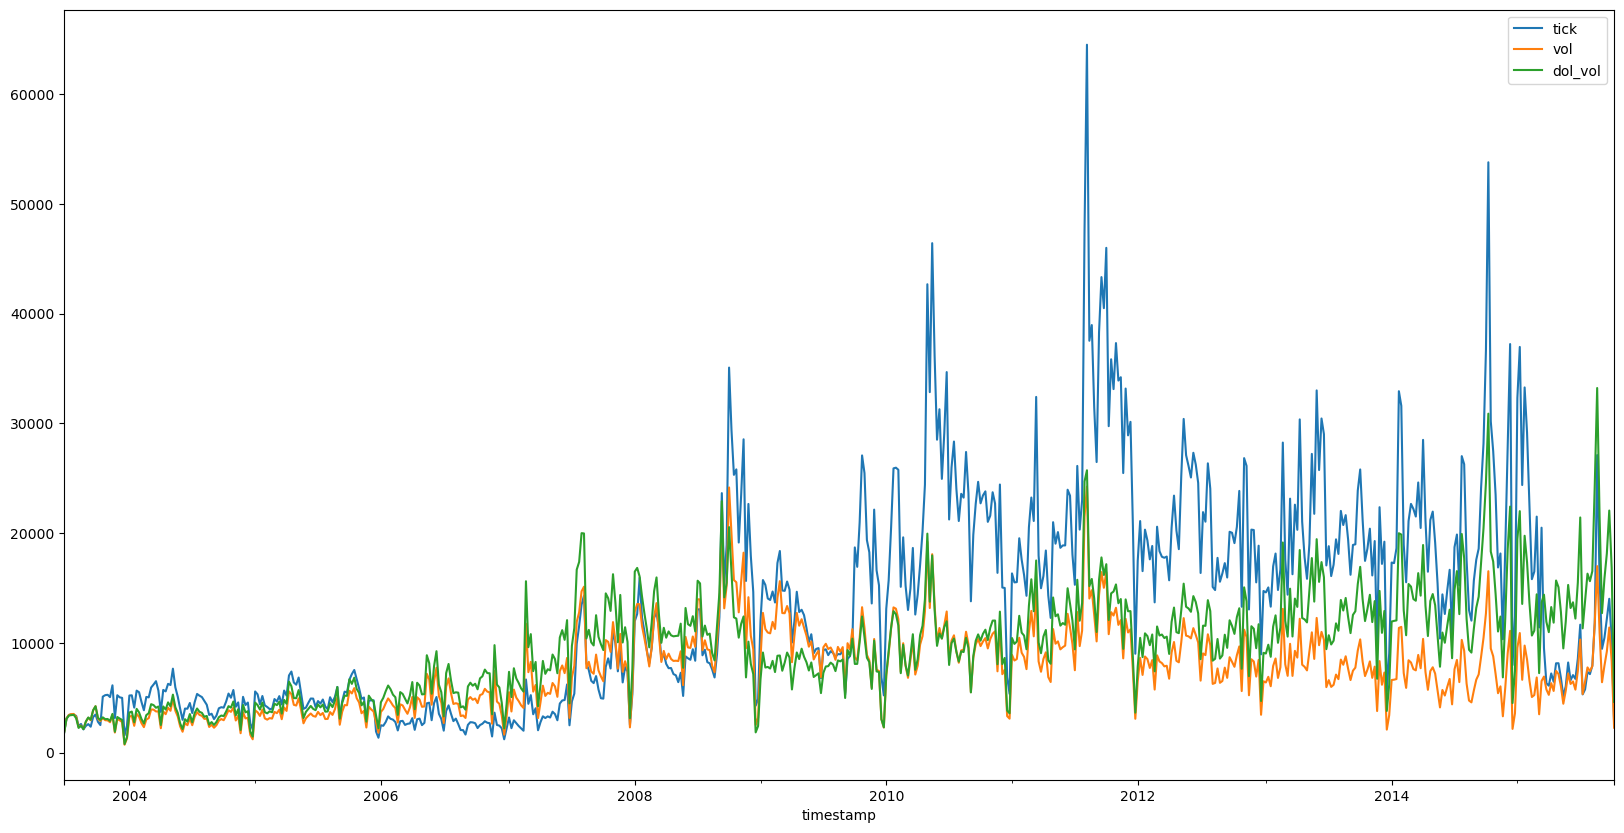

In [6]:
# plotting weekly bar count
df_week.plot(figsize=(20, 10))

### Scaled weekly count
So that we can compare all the 3 different bars

In [7]:
scaler = MinMaxScaler()
df_week_scaled = pd.DataFrame(scaler.fit_transform(df_week.values), columns=df_week.columns, index=df_week.index)

<Axes: xlabel='timestamp'>

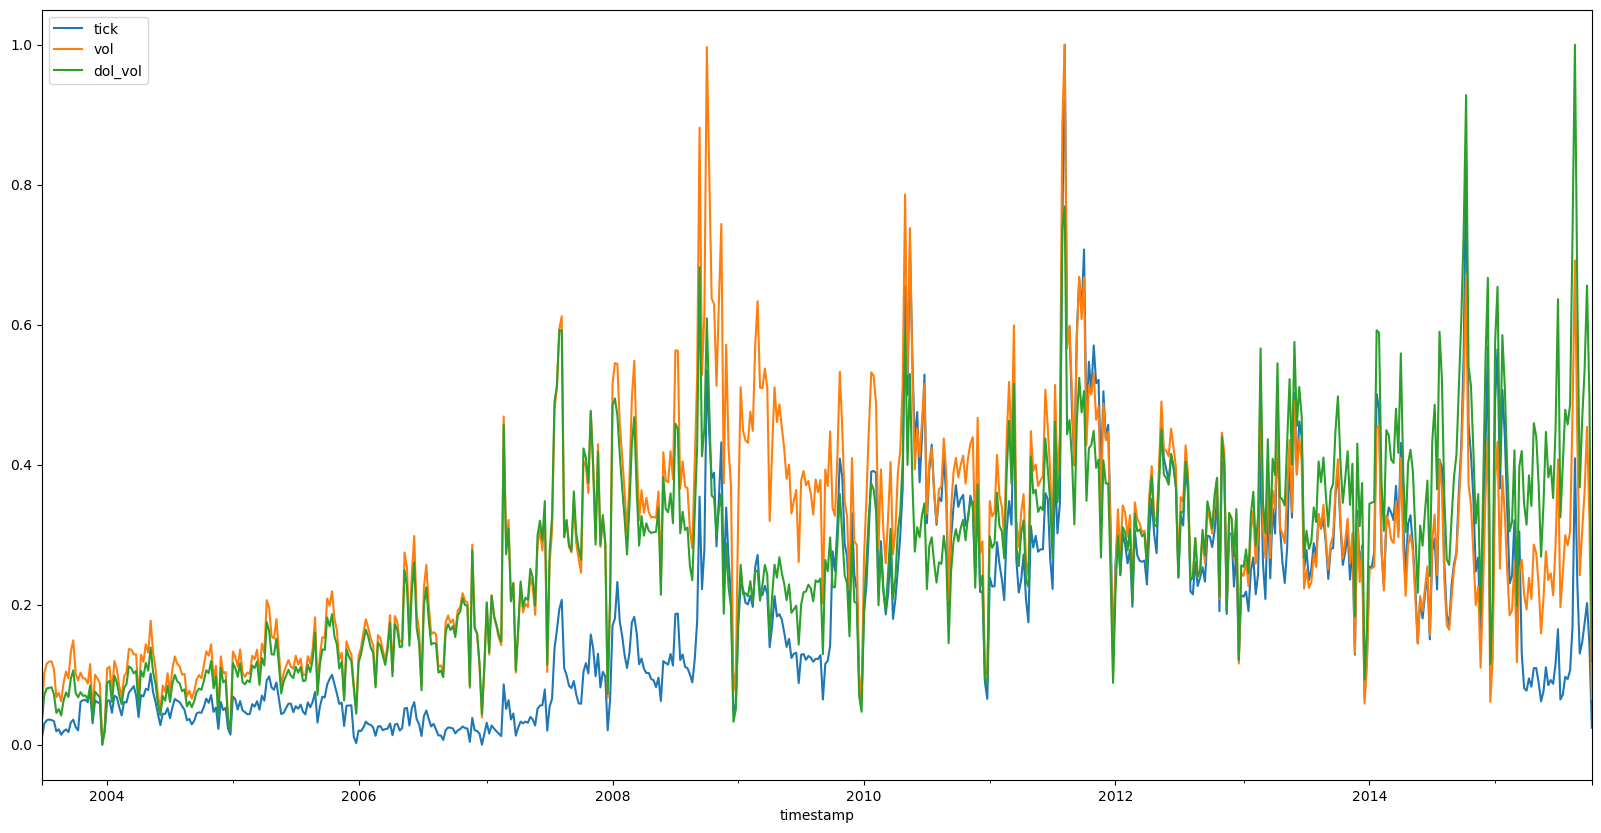

In [8]:
# plotting standardized weekly bar count
df_week_scaled.plot(figsize=(20, 10))

<Axes: xlabel='timestamp'>

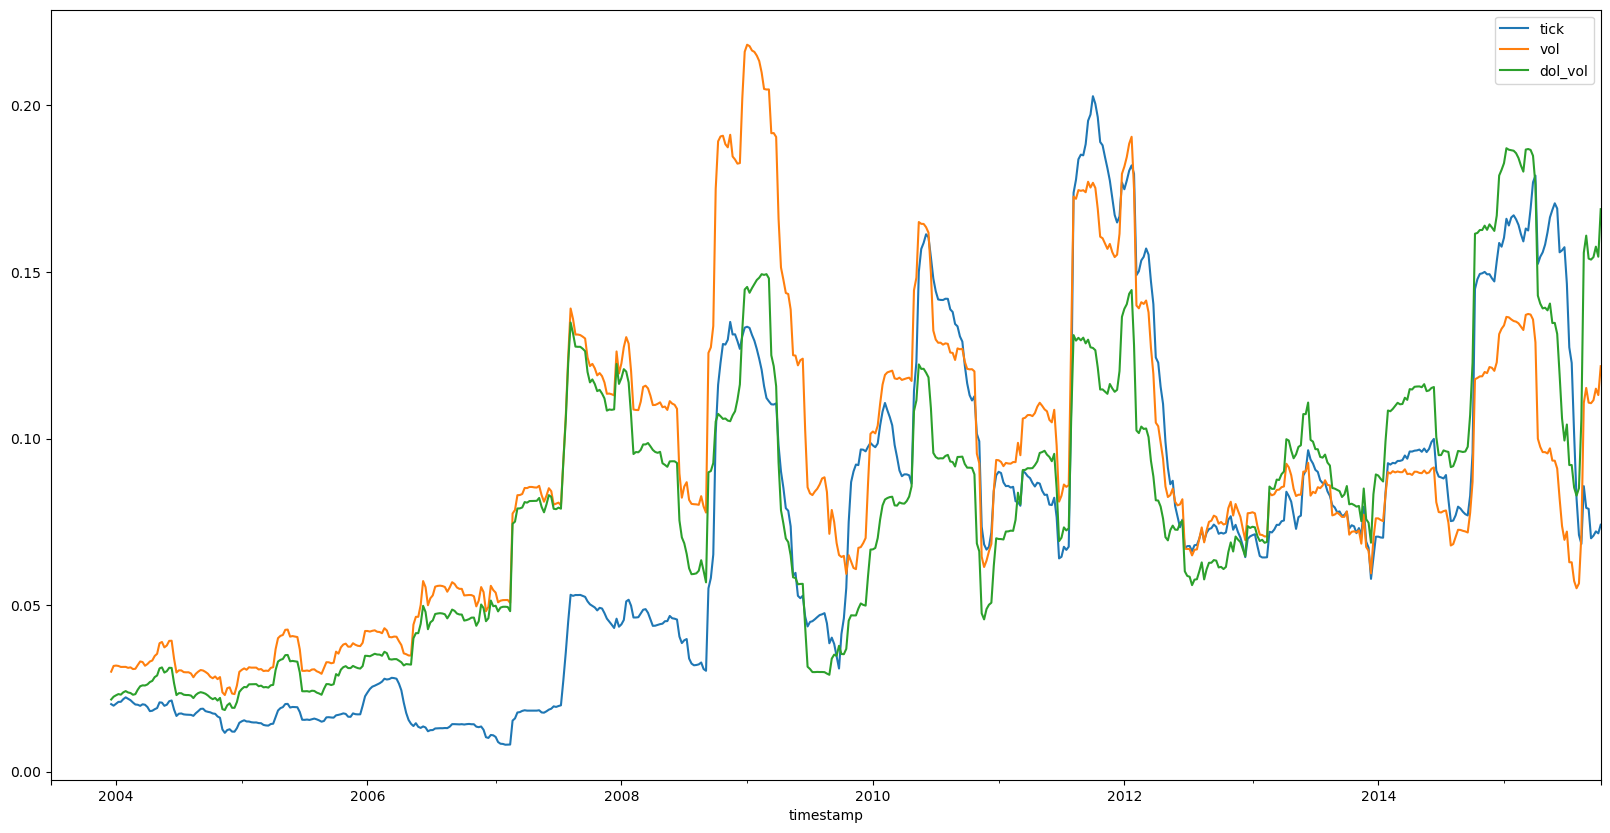

In [9]:
# plotting rolling standard deviation
df_week_scaled.rolling(26).std().plot(figsize=(20, 10))

In [10]:
for c in df_week_scaled.columns:
    print(c,'-',np.std(df_week_scaled[c]))    

tick - 0.15383652494711675
vol - 0.15534521029470058
dol_vol - 0.149168489875176


Time bars, although popular, are problematic as markets do not consistently process information at constant time intervals. The varying intensity of trading activity, such as the heightened activity in the first hour after the market opens, challenges the efficacy of time bars in capturing market dynamics accurately.This is the reason why we have to use other sampling techniques that are more representitive of the actual flow of information in the market, like the 3 bars we created. 

We can see that dollar volume bar has the least standard deviation among the 3 and the above plots show also shows that the weekly count is rather consistent relative to tick and volume bar. Also, dollar bars seems a superior sampling approach due to their consideration of the actual value exchanged, providing a more meaningful representation than tick or volume bars that fails to take in the effects of changes in price into the sampling rate. 

In the AFML book by Dr. Marcos Lopez, he gives an intuitive example that explains why the number of shares traded is related to the exchanged dollar value and its goes like this
> First, suppose that we wish to analyze a stock that has exhibited an appreciation of 100% over a certain period of time. Selling $1,000 worth of that stock at the end of the period requires trading half the number of shares it took to buy $1,000 worth of that stock at the beginning. In other words, the number of shares traded is a function of the actual value exchanged. 

# 3.2 Serial Correlation

In [11]:
df_tick_bars['returns'] = df_tick_bars['close'].pct_change()
df_volume_bars['returns'] = df_volume_bars['close'].pct_change()
df_dol_vol_bars['returns'] = df_dol_vol_bars['close'].pct_change()

df_tick_bars.dropna(inplace=True)
df_volume_bars.dropna(inplace=True)
df_dol_vol_bars.dropna(inplace=True)

Plotting the correlogram of a small sample size to see if there's an correlation in different lags of the time series

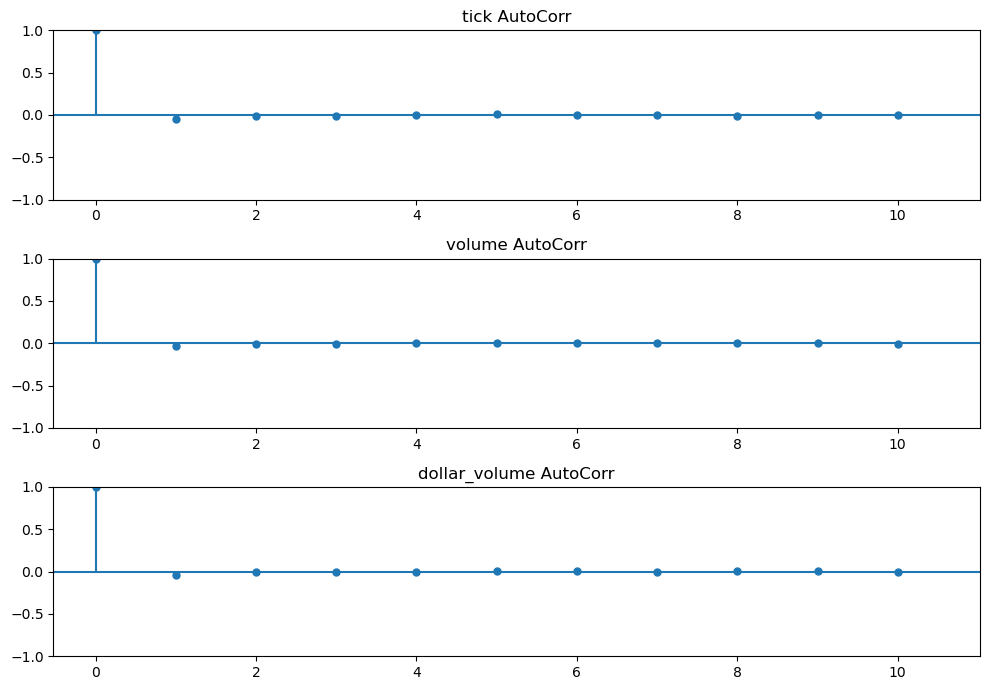

In [12]:
bar_type_dict = {'tick':df_tick_bars,
                 'volume':df_volume_bars,
                 'dollar_volume':df_dol_vol_bars
                }
i = 0
f, axes = plt.subplots(3,figsize=(10,7))
for bar_type in bar_type_dict:
    tsp.plot_acf(x=bar_type_dict[bar_type][:100000]['returns'].dropna(), lags = 10 , alpha =0.05,title = f'{bar_type} AutoCorr',ax=axes[i])
    i+=1
    # plt.show()
    plt.tight_layout()

In [13]:
# here are the correlation number at 1st lag
for bar_type in bar_type_dict:
    print("{} Autocorrelation: {:.4f}".format(bar_type,bar_type_dict[bar_type]['returns'].autocorr(lag=1)))

tick Autocorrelation: -0.0479
volume Autocorrelation: -0.0151
dollar_volume Autocorrelation: -0.0201


We can see that serial correlation (at lag 1) is not that significant for any of the bars and is the lowest is for the volume bar.

# 3.3 Monthly subset
Checking for heteroskedasticity

In [14]:
month_tick_ret_var = df_tick_bars.set_index('timestamp')['returns'].resample('M').var().rename('tick')
month_vol_ret_var = df_volume_bars.set_index('timestamp')['returns'].resample('M').var().rename('vol')
month_dol_vol_ret_var = df_dol_vol_bars.set_index('timestamp')['returns'].resample('M').var().rename('dol_vol')

In [15]:
df_month_var = pd.concat([month_tick_ret_var,month_vol_ret_var,month_dol_vol_ret_var],axis=1)

<Axes: xlabel='timestamp'>

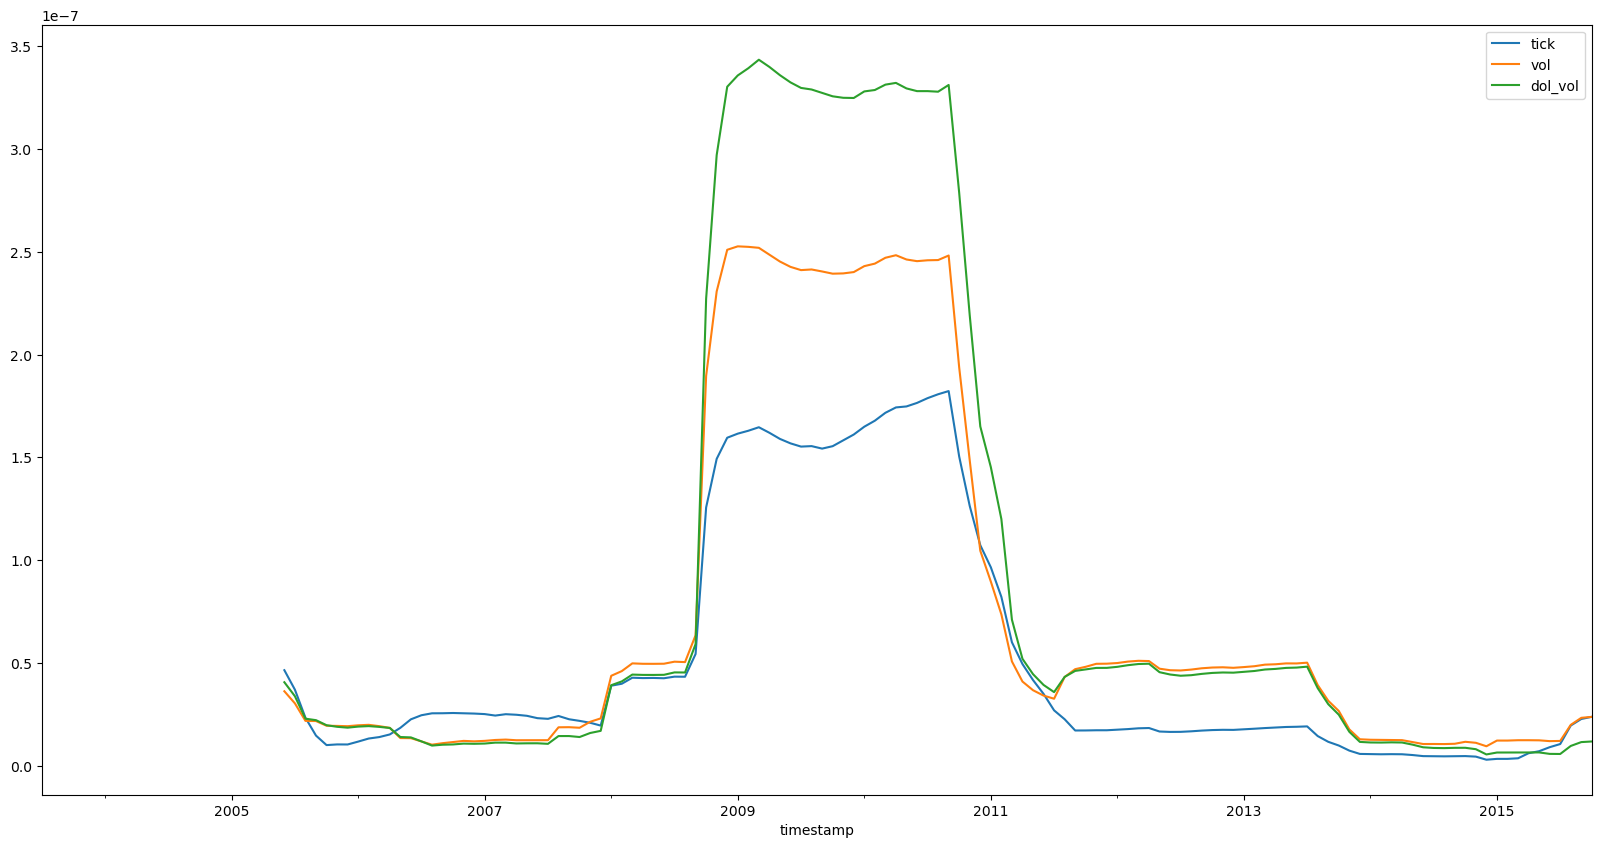

In [16]:
# plotting rolling variance
df_month_var.rolling(24).std().plot(figsize=(20, 10))

In [17]:
df_month_var.var().sort_values(ascending=True)

tick       9.108760e-15
vol        1.488018e-14
dol_vol    2.636483e-14
dtype: float64

We can see that tick bar has the lowest variances of variance.

# 3.4 Normality test

In [19]:
print("Tick Bar - {}".format(jarque_bera(df_tick_bars['returns'])))
print("Volume Bar - {}".format(jarque_bera(df_volume_bars['returns'])))
print("Dollar volume Bar - {}".format(jarque_bera(df_dol_vol_bars['returns'])))

Tick Bar - SignificanceResult(statistic=2459038448.377625, pvalue=0.0)
Volume Bar - SignificanceResult(statistic=750158018.8710644, pvalue=0.0)
Dollar volume Bar - SignificanceResult(statistic=2264753464.8242593, pvalue=0.0)


We can see that 3 types of bars do not follow a normal distribution according to the Jarque Bera test.

Text(0.5, 1.0, 'KDE of Standard Price & Volume Bars')

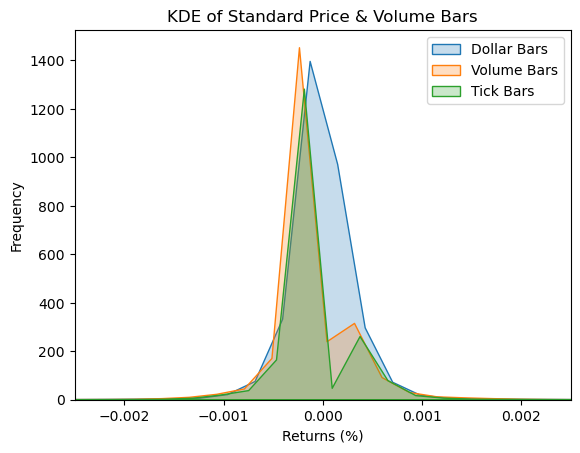

In [20]:
sns.kdeplot(df_dol_vol_bars['returns'], shade=True, label='Dollar Bars')
sns.kdeplot(df_volume_bars['returns'],shade=True, label='Volume Bars')
sns.kdeplot(df_tick_bars['returns'], shade=True, label='Tick Bars')

plt.xlim(-0.0025,0.0025)

plt.legend()
plt.xlabel('Returns (%)')
plt.ylabel('Frequency')
plt.title('KDE of Standard Price & Volume Bars')


In [21]:
# plotting distributon of the log returns 
df_tick_bars['log_returns'] = np.log(df_tick_bars['close']/df_tick_bars['close'].shift(1))#.dropna()
df_volume_bars['log_returns'] = np.log(df_volume_bars['close']/df_volume_bars['close'].shift(1))#.dropna()
df_dol_vol_bars['log_returns'] = np.log(df_dol_vol_bars['close']/df_dol_vol_bars['close'].shift(1))#.dropna()

Text(0.5, 1.0, 'KDE of Standard Price & Volume Bars')

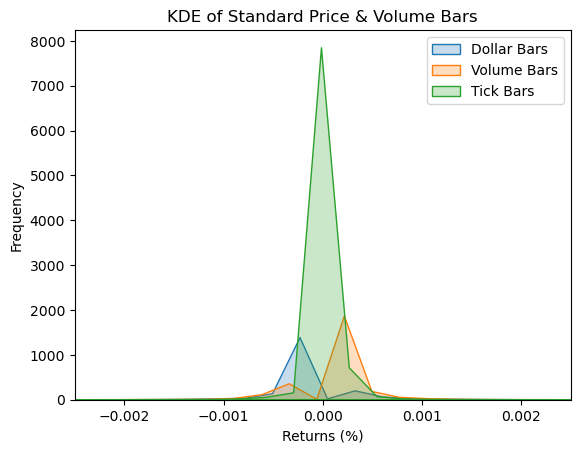

In [22]:
sns.kdeplot(df_dol_vol_bars['log_returns'], shade=True, label='Dollar Bars')
sns.kdeplot(df_volume_bars['log_returns'],  shade=True, label='Volume Bars')
sns.kdeplot(df_tick_bars['log_returns'],  shade=True, label='Tick Bars')

plt.xlim(-0.0025,0.0025)

plt.legend()
plt.xlabel('Returns (%)')
plt.ylabel('Frequency')
plt.title('KDE of Standard Price & Volume Bars')